In [1]:
# https://blog.csdn.net/s09094031/article/details/92428209?app_version=6.3.1&csdn_share_tail=%7B%22type%22%3A%22blog%22%2C%22rType%22%3A%22article%22%2C%22rId%22%3A%2292428209%22%2C%22source%22%3A%22unlogin%22%7D&utm_source=app

In [2]:
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob

import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

ROOT = '/kaggle/input/home-credit-credit-risk-model-stability'

In [3]:
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

In [4]:
class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  #!!?
                df = df.with_columns(pl.col(col).dt.total_days()) # t - t-1
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.7:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        
        return df

In [5]:
class Aggregator:
    
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        return expr_max
    
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        return expr_max
    
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        return expr_max
    
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        return expr_max
    
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]  # max & replace col name
        return expr_max
    
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [6]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df

def read_files(regex_path, depth=None):
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

In [7]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

In [8]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols

In [9]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")

TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [10]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        read_file(TRAIN_DIR / "train_applprev_2.parquet", 2),
        read_file(TRAIN_DIR / "train_person_2.parquet", 2)
    ]
}

In [11]:
df_train = feature_eng(**data_store)
print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 487)


In [12]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        read_file(TEST_DIR / "test_applprev_2.parquet", 2),
        read_file(TEST_DIR / "test_person_2.parquet", 2)
    ]
}

In [13]:
df_test = feature_eng(**data_store)
print("test data shape:\t", df_test.shape)

test data shape:	 (10, 486)


### Feature Selection

In [14]:
# drop_list = ['max_empl_employedtotal_800L', 'monthsannuity_845L', 'lastactivateddate_801D', 
#              'max_numberofoverdueinstls_725L', 'requesttype_4525192L', 'max_pmts_year_507T', 
#              'lastrejectcommodtypec_5251769M', 'numinstpaidlate1d_3546852L', 'numinstmatpaidtearly2d_4499204L', 
#              'max_overdueamountmaxdateyear_2T', 'max_overdueamountmaxdateyear_994T', 'twobodfilling_608L', 
#              'maxdpdlast12m_727P', 'numinsttopaygrest_4493213L', 'currdebtcredtyperange_828A', 'maxdpdlast9m_1059P', 
#              'numinstpaid_4499208L', 'applicationscnt_867L', 'numinstlswithoutdpd_562L', 'fourthquarter_440L', 
#              'max_num_group1_6', 'max_safeguarantyflag_411L', 'max_dpdmaxdateyear_896T', 'numinstregularpaid_973L', 
#              'avgdbdtollast24m_4525197P', 'numinstpaidearly5dest_4493211L', 'numinstpaidearly5dobd_4499205L', 
#              'homephncnt_628L', 'max_role_1084L', 'max_remitter_829L', 'numrejects9m_859L', 
#              'numinstlallpaidearly3d_817L', 'numinstpaidearly3dest_4493216L', 'annuitynextmonth_57A', 
#              'numinstregularpaidest_4493210L', 'firstquarter_103L', 'clientscnt_533L', 'maxdpdlast3m_392P', 
#              'sellerplacescnt_216L', 'secondquarter_766L', 'max_periodicityofpmts_1102L', 'numinstlsallpaid_934L', 
#              'opencred_647L', 'numinstls_657L', 'numactivecredschannel_414L', 'numinstpaidearly3d_3546850L', 
#              'numinstpaidearlyest_4493214L', 'max_totaldebtoverduevalue_718A', 'paytype1st_925L', 
#              'max_inittransactioncode_279L', 'max_contractst_545M', 'max_cancelreason_3545846M', 
#              'max_rejectreason_755M', 'max_personindex_1023L', 'max_subjectroles_name_838M', 'maxdpdlast6m_474P', 
#              'max_subjectrole_182M', 'actualdpdtolerance_344P', 'max_num_group1_9', 'max_collaterals_typeofguarante_669M', 
#              'numinstpaidearly_338L', 'clientscnt_887L', 'maritalst_893M', 'max_subjectrole_93M', 'max_type_25L', 
#              'max_refreshdate_3813885D', 'numinstpaidearly5d_1087L', 'max_actualdpd_943P', 'max_description_351M', 
#              'education_88M', 'clientscnt_946L', 'clientscnt12m_3712952L', 'numactiverelcontr_750L', 
#              'max_education_927M', 'applicationscnt_1086L', 'sellerplacecnt_915L', 'max_purposeofcred_426M', 
#              'max_subjectroles_name_541M', 'clientscnt_1022L', 'clientscnt_360L', 'max_totaloutstanddebtvalue_668A', 
#              'applicationscnt_629L', 'max_outstandingamount_354A', 'clientscnt_1071L', 'numactivecreds_622L', 
#              'clientscnt_493L', 'paytype_783L', 'clientscnt6m_3712949L', 'clientscnt_304L', 'max_classificationofcontr_13M', 
#              'numnotactivated_1143L', 'commnoinclast6m_3546845L', 'max_numberofoutstandinstls_520L', 
#              'applicationscnt_464L', 'clientscnt_1130L', 'max_numberofoverdueinstls_834L', 'clientscnt3m_3712950L', 
#              'max_rejectreasonclient_4145042M', 'max_contaddr_smempladdr_334L', 'numpmtchanneldd_318L', 
#              'numcontrs3months_479L', 'max_overdueamount_31A', 'max_collaterals_typeofguarante_359M', 
#              'clientscnt_257L', 'clientscnt_157L', 'applications30d_658L', 'clientscnt_100L', 
#              'max_collater_typofvalofguarant_298M', 'max_pmts_month_706T', 'max_pmts_month_158T', 
#              'mastercontrexist_109L', 'max_collater_typofvalofguarant_407M', 'mastercontrelectronic_519L', 
#              'applicationcnt_361L', 'max_persontype_1072L', 'max_empladdr_district_926M', 'deferredmnthsnum_166L', 
#              'max_empladdr_zipcode_114M', 'max_persontype_792L', 'max_contaddr_matchlist_1032L']

In [15]:
# df_train = df_train.drop(drop_list)
# df_test = df_test.drop(drop_list)

In [16]:
# Drop the insignificant features
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1526659, 327)
test data shape:	 (10, 326)


In [17]:
df_train, cat_cols = to_pandas(df_train)
df_test, cat_cols = to_pandas(df_test, cat_cols)

In [18]:
del data_store
gc.collect()

0

In [19]:
display(df_train.head())
display(df_test.head())

,case_id,WEEK_NUM,target,month_decision,weekday_decision,birthdate_574D,dateofbirth_337D,days120_123L,days180_256L,days30_165L,...,max_num_group2_13,max_cacccardblochreas_147M,max_conts_type_509L,max_num_group1_14,max_num_group2_14,max_conts_role_79M,max_empls_economicalst_849M,max_empls_employer_name_740M,max_num_group1_15,max_num_group2_15
0,0,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,1,5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,PRIMARY_MOBILE,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,3,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,PRIMARY_MOBILE,0.0,2.0,NaN,NaN,NaN,NaN,NaN
4,4,0,1,1,5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,PRIMARY_MOBILE,0.0,1.0,NaN,NaN,NaN,NaN,NaN


,case_id,WEEK_NUM,month_decision,weekday_decision,birthdate_574D,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,...,max_num_group2_13,max_cacccardblochreas_147M,max_conts_type_509L,max_num_group1_14,max_num_group2_14,max_conts_role_79M,max_empls_economicalst_849M,max_empls_employer_name_740M,max_num_group1_15,max_num_group2_15
0,57543,100,5,5,NaN,-14804,2.0,4.0,1.0,8.0,...,0.0,a55475b1,PRIMARY_MOBILE,4.0,1.0,NaN,NaN,NaN,NaN,NaN
1,57549,100,1,1,NaN,-22723,6.0,9.0,3.0,12.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,57551,100,11,5,NaN,-14090,1.0,3.0,1.0,4.0,...,0.0,NaN,NaN,NaN,NaN,a55475b1,a55475b1,a55475b1,0.0,0.0
3,57552,100,11,5,NaN,-23768,2.0,2.0,0.0,5.0,...,NaN,NaN,NaN,NaN,NaN,a55475b1,a55475b1,a55475b1,0.0,0.0
4,57569,100,12,1,NaN,-26408,4.0,4.0,1.0,4.0,...,8.0,NaN,NaN,NaN,NaN,a55475b1,a55475b1,a55475b1,1.0,5.0


### Handle categorical features (Ordinal encoding)

In [20]:
# cat_list = [col for col in df_train.columns if df_train[col].dtype.name == 'category']

# catfreq_dict = {}
# catcatfreq_dict = {}

# for col in cat_list:
#     catfreq_dict[col] = len(list(df_train[col].value_counts()))
#     catcatfreq_dict[col] = {}
#     for d in dict(df_train[col].value_counts()).items():
#         catcatfreq_dict[col][d[0]] = d[1]

# catfreq_df = pd.DataFrame.from_dict(catfreq_dict, orient='index', columns=['Categories'])
# display(catfreq_df.sort_values(by="Categories", ascending=False).head())
# display(catfreq_df.sort_values(by="Categories", ascending=True).head())

In [21]:
# ordinal_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
# df_train[cat_list] = ordinal_enc.fit_transform(df_train[cat_list])
# df_test[cat_list] = ordinal_enc.transform(df_test[cat_list])
# df_train[cat_list].head()

### Handle NaN

In [22]:
# nan_list = []
# for col, boo in df_train.isnull().any().items():
#     if boo == True:
#         nan_list.append(col)

# print(f"Number of col contains Nan value: {len(nan_list)}")
# for i, v in df_train.isna().sum().items():
#     if v/len(df_train)>0.6:
#         print(f"{i} : \t {round((v/len(df_train))*100)}% Nan ")

In [23]:
# ### trial
# from sklearn.impute import SimpleImputer
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# df_train[nan_list] = imp.fit_transform(df_train[nan_list])
# df_test[nan_list] = imp.transform(df_test[nan_list])

In [24]:
# ## no work (too slow..) 
# ## require dimensionality reduction first & features with high feature impor. 
# imputer = KNNImputer()
# df_train = imputer.fit_transform(df_train)

In [25]:
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,  
    "learning_rate": 0.05,
    "n_estimators": 2000,  
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "reg_alpha": 0.1,
    "reg_lambda": 10,
    "extra_trees":True,
    'num_leaves':64,
    "device": "gpu", 
    "verbose": -1,
}

fitted_models = []
cv_scores = []

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set = [(X_valid, y_valid)],
        callbacks = [lgb.log_evaluation(200), lgb.early_stopping(60)] )
    fitted_models.append(model)
    
    y_pred_valid = model.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)
    
print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 60 rounds
[200]	valid_0's auc: 0.845208
[400]	valid_0's auc: 0.850099
[600]	valid_0's auc: 0.851801
[800]	valid_0's auc: 0.85253
[1000]	valid_0's auc: 0.852846
[1200]	valid_0's auc: 0.853116
Early stopping, best iteration is:
[1222]	valid_0's auc: 0.853167
Training until validation scores don't improve for 60 rounds
[200]	valid_0's auc: 0.846803
[400]	valid_0's auc: 0.85177
[600]	valid_0's auc: 0.853468
[800]	valid_0's auc: 0.853962
[1000]	valid_0's auc: 0.854398
[1200]	valid_0's auc: 0.854678
Early stopping, best iteration is:
[1254]	valid_0's auc: 0.854708
Training until validation scores don't improve for 60 rounds
[200]	valid_0's auc: 0.850481
[400]	valid_0's auc: 0.855925
[600]	valid_0's auc: 0.857804
[800]	valid_0's auc: 0.858529
[1000]	valid_0's auc: 0.858729
Early stopping, best iteration is:
[1085]	valid_0's auc: 0.858881
Training until validation scores don't improve for 60 rounds
[200]	valid_0's auc: 0.850137
[400]	valid_0's

In [26]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

model = VotingModel(fitted_models)

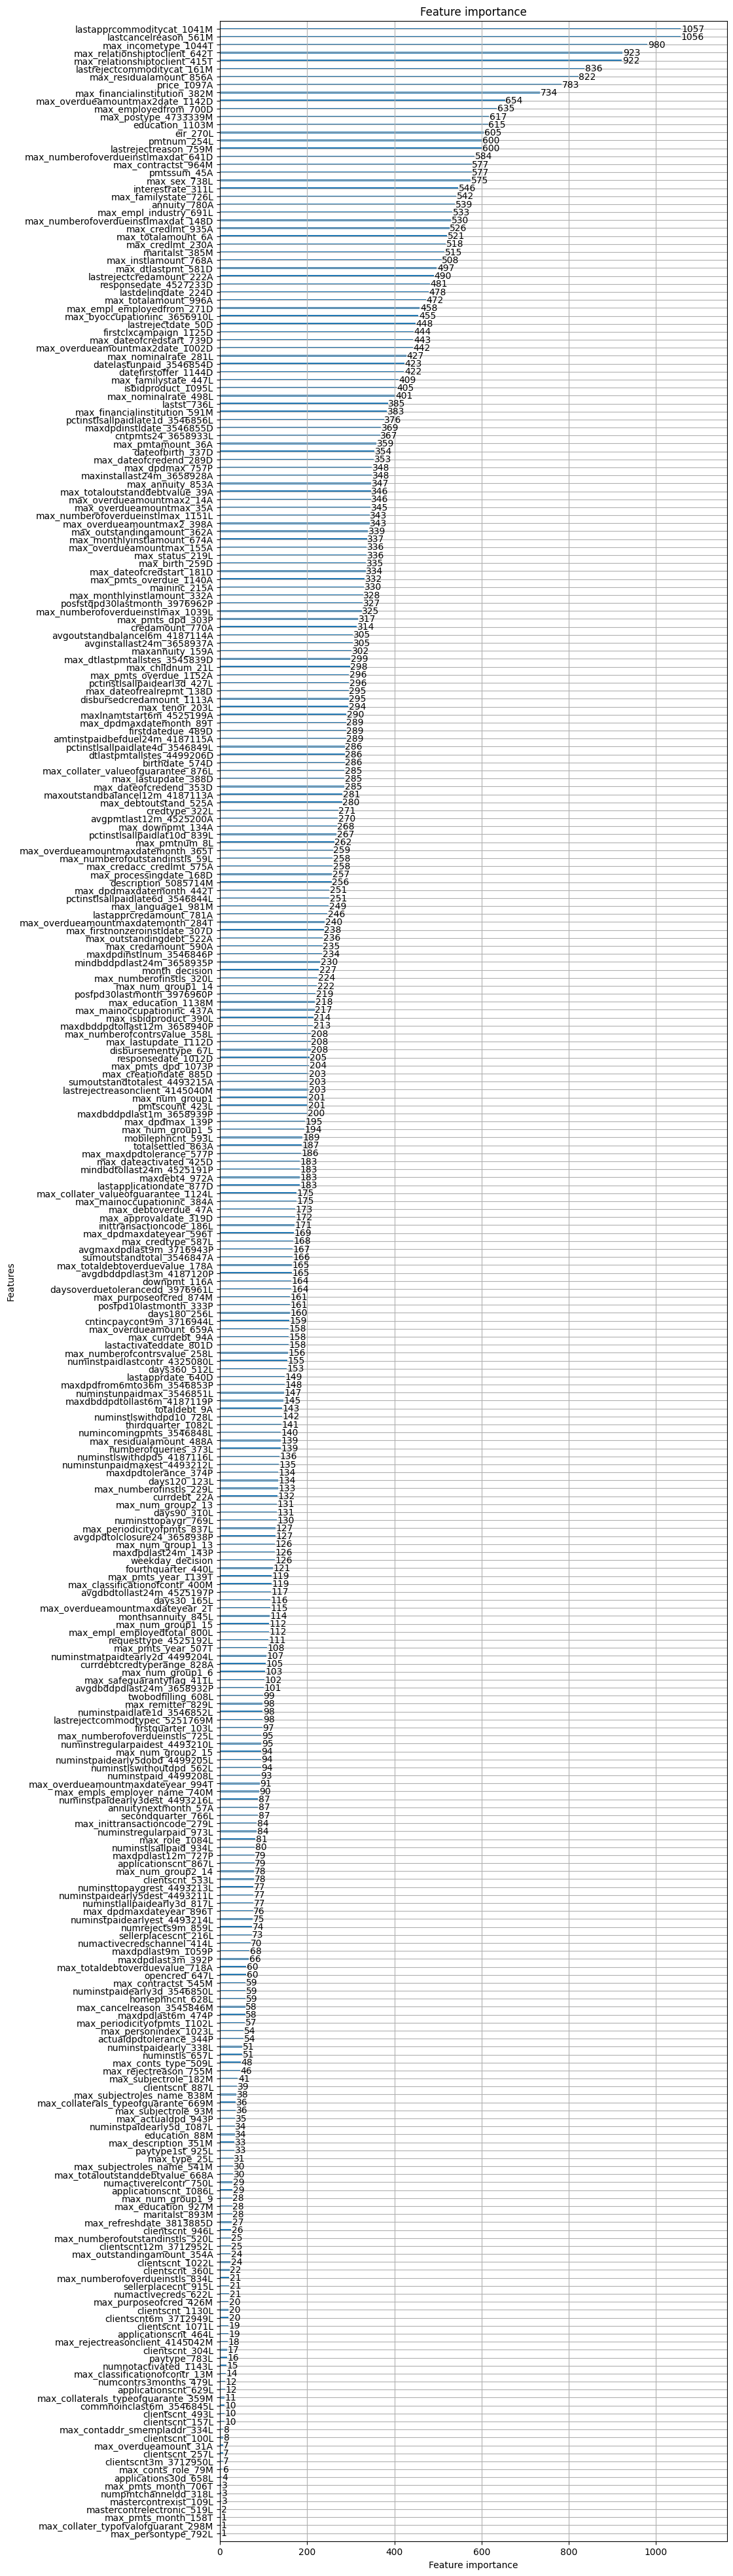

In [27]:
lgb.plot_importance(fitted_models[2], importance_type="split", figsize=(10,50))
plt.show()

In [28]:
features = X_train.columns
importances = fitted_models[2].feature_importances_
feature_importance = pd.DataFrame({'importance':importances,'features':features}).sort_values('importance', ascending=False).reset_index(drop=True)
feature_importance

,importance,features
0,1057,lastapprcommoditycat_1041M
1,1056,lastcancelreason_561M
2,980,max_incometype_1044T
3,923,max_relationshiptoclient_642T
4,922,max_relationshiptoclient_415T
...,...,...
319,0,max_empls_economicalst_849M
320,0,max_cacccardblochreas_147M
321,0,max_empladdr_district_926M
322,0,max_empladdr_zipcode_114M


In [29]:
drop_list = []
for i, f in feature_importance.iterrows():
    if f['importance']<80:
        drop_list.append(f['features'])
print(f"Number of features which are not important: {len(drop_list)} ")

Number of features which are not important: 95 


In [30]:
print(drop_list)

['applicationscnt_867L', 'maxdpdlast12m_727P', 'max_num_group2_14', 'clientscnt_533L', 'numinstpaidearly5dest_4493211L', 'numinstlallpaidearly3d_817L', 'numinsttopaygrest_4493213L', 'max_dpdmaxdateyear_896T', 'numinstpaidearlyest_4493214L', 'numrejects9m_859L', 'sellerplacescnt_216L', 'numactivecredschannel_414L', 'maxdpdlast9m_1059P', 'maxdpdlast3m_392P', 'max_totaldebtoverduevalue_718A', 'opencred_647L', 'homephncnt_628L', 'numinstpaidearly3d_3546850L', 'max_contractst_545M', 'max_cancelreason_3545846M', 'maxdpdlast6m_474P', 'max_periodicityofpmts_1102L', 'actualdpdtolerance_344P', 'max_personindex_1023L', 'numinstls_657L', 'numinstpaidearly_338L', 'max_conts_type_509L', 'max_rejectreason_755M', 'max_subjectrole_182M', 'clientscnt_887L', 'max_subjectroles_name_838M', 'max_collaterals_typeofguarante_669M', 'max_subjectrole_93M', 'max_actualdpd_943P', 'education_88M', 'numinstpaidearly5d_1087L', 'max_description_351M', 'paytype1st_925L', 'max_type_25L', 'max_totaloutstanddebtvalue_668A

### Submission

In [31]:
X_test = df_test.drop(columns=["WEEK_NUM"])
X_test = X_test.set_index("case_id")

lgb_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

In [32]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = lgb_pred

In [33]:
df_subm.head()

,score
case_id,
57543,0.003216
57549,0.056997
57551,0.001622
57552,0.014610
57569,0.118173


In [34]:
df_subm.to_csv("submission.csv")

* handle nan value (both numeric & categorical)
* preprocess the minority categorical value (drop / keep)
* float to int after ordinal encode
* oversampling (smote? (considering date feature)
* high dimension (pca) 
* create new features based on high fea_imp features
...
...

In [35]:
# X_resampled, y_resampled = SMOTE().fit_resample(X, y)